In [109]:
!pip install scikit-learn
!pip install keras
!pip install np_utils
!pip install scikeras

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import layers, models, optimizers
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Download dataset
path = kagglehub.dataset_download("rajeevw/ufcdata")

print("Path to dataset files:", path)
data_df = pd.read_csv(path + '/data.csv')
data_df.head()

Path to dataset files: /root/.cache/kagglehub/datasets/rajeevw/ufcdata/versions/2


,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,...,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Adrian Yanez,Gustavo Lopez,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Bantamweight,0.000,0.0,...,0,1,0,0,Orthodox,170.18,177.80,135.0,31.0,27.0
1,Trevin Giles,Roman Dolidze,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Middleweight,0.500,0.0,...,0,3,0,0,Orthodox,182.88,187.96,185.0,32.0,28.0
2,Tai Tuivasa,Harry Hunsucker,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Heavyweight,NaN,NaN,...,1,3,0,0,Southpaw,187.96,190.50,264.0,32.0,28.0
3,Cheyanne Buys,Montserrat Conejo,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenStrawweight,NaN,NaN,...,0,0,0,0,Switch,160.02,160.02,115.0,28.0,25.0
4,Marion Reneau,Macy Chiasson,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenBantamweight,0.125,0.0,...,1,2,2,0,Orthodox,167.64,172.72,135.0,29.0,43.0


In [111]:
data_df = data_df.dropna()
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3890 entries, 0 to 5884
Columns: 144 entries, R_fighter to R_age
dtypes: bool(1), float64(106), int64(28), object(9)
memory usage: 4.3+ MB


In [112]:
data_df.drop(columns=['R_fighter', 'B_fighter', 'Referee', 'date', 'location','weight_class'], inplace=True)

In [113]:
# Split the dataframe into two: one for red fighters and one for blue fighters
# Remove the R_ and B_ prefixes from the column names, but only the first occurrence (prefix)
# indicate whether the fighter won or lost the fight
data_df = data_df[data_df["Winner"] != "Draw"]

df_red = data_df.filter(regex='^R_|^date|^Winner|^B_Stance|^B_age').rename(columns=lambda x: x.replace('R_', '', 1)).rename(columns=lambda x: x.replace('B_Stance', 'Opp_Stance', 1)).rename(columns=lambda x: x.replace('B_age', 'Opp_age', 1))
df_red['Winner'] = df_red['Winner'].replace({'Red': 1, 'Blue': 0})

df_blue = data_df.filter(regex='^B_|^date|^Winner|^R_Stance|^R_age').rename(columns=lambda x: x.replace('B_', '', 1)).rename(columns=lambda x: x.replace('R_Stance', 'Opp_Stance', 1)).rename(columns=lambda x: x.replace('R_age', 'Opp_age', 1))
df_blue['Winner'] = df_blue['Winner'].replace({'Red': 0, 'Blue': 1})

# Concatenate the two dataframes
df_fighters = pd.concat([df_red, df_blue])

df_fighters['age_differential'] = df_fighters['age'] - df_fighters['Opp_age']
df_fighters.drop('Opp_age', axis=1, inplace=True)

# Create age categories
df_fighters['age_group'] = pd.cut(df_fighters['age'], bins=[0, 25, 30, 35, float('inf')], labels=['Under 25', '25-30', '30-35', 'Over 35'], right=False)

# One-hot encode the age groups
age_group_dummies = pd.get_dummies(df_fighters['age_group'], prefix='Age_Group')
df_fighters = pd.concat([df_fighters, age_group_dummies], axis=1)
df_fighters.drop('age_group', axis=1, inplace=True)

# Create columns for each stance
stance_dummies = pd.get_dummies(df_fighters['Stance'], prefix='Stance')
df_fighters = pd.concat([df_fighters, stance_dummies], axis=1)
df_fighters.drop('Stance', axis=1, inplace=True)

opp_stance_dummies = pd.get_dummies(df_fighters['Opp_Stance'], prefix='Opp_Stance')
df_fighters = pd.concat([df_fighters, opp_stance_dummies], axis=1)
df_fighters.drop('Opp_Stance', axis=1, inplace=True)

# Reset the index (to ensure each fighter has a unique index, instead of a shared index)
df_fighters = df_fighters.reset_index(drop=True)

df_fighters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7642 entries, 0 to 7641
Data columns (total 81 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Winner                      7642 non-null   int64  
 1   avg_KD                      7642 non-null   float64
 2   avg_opp_KD                  7642 non-null   float64
 3   avg_SIG_STR_pct             7642 non-null   float64
 4   avg_opp_SIG_STR_pct         7642 non-null   float64
 5   avg_TD_pct                  7642 non-null   float64
 6   avg_opp_TD_pct              7642 non-null   float64
 7   avg_SUB_ATT                 7642 non-null   float64
 8   avg_opp_SUB_ATT             7642 non-null   float64
 9   avg_REV                     7642 non-null   float64
 10  avg_opp_REV                 7642 non-null   float64
 11  avg_SIG_STR_att             7642 non-null   float64
 12  avg_SIG_STR_landed          7642 non-null   float64
 13  avg_opp_SIG_STR_att         7642 

In [114]:
X = df_fighters.drop(columns=['Winner'])
Y = df_fighters['Winner']

In [115]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
print("Training size = " + str(X_train.shape[0]))
print("Testing size = " + str(X_test.shape[0]))

Training size = 5731
Testing size = 1911


In [116]:
seed = 404
np.random.seed(seed)

# Logistic Regression

In [117]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter = 10000, class_weight='balanced')
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(lr, X_train, y_train.values.ravel(), cv=kfold)
lr_score = cv_score.mean()
print('Logistic Regression K-fold Scores (training):')
print(cv_score)
print()
print('Logistic Regression Average Score:')
print(lr_score)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression K-fold Scores (training):
[0.57317073 0.57068063 0.60907504 0.56020942 0.56369983 0.57766143
 0.52530541 0.62303665 0.58987784 0.59162304]

Logistic Regression Average Score:
0.5784340016175031


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


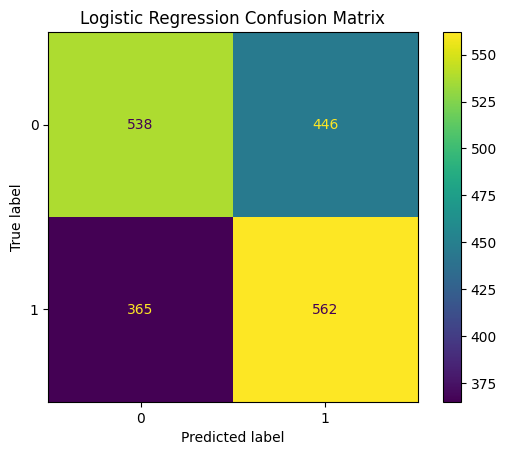

Logistic Regression Model Accuracy (on testing set): 
0.5756148613291471


In [118]:
lr = LogisticRegression(max_iter = 10000)
lr_model = lr.fit(X_train, y_train.values.ravel())
y_pred = lr_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=lr.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()
disp.ax_.set_title('Logistic Regression Confusion Matrix')
plt.show()
print('Logistic Regression Model Accuracy (on testing set): ')
print(accuracy_score(y_test, y_pred))

# Neural Network

In [151]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_Train = to_categorical(encoded_Y)

encoder = LabelEncoder()
encoder.fit(y_test)
y_Test = encoder.transform(y_test)

In [152]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# from keras import layers, models, optimizers


def create_model():
    model = Sequential()
    # Input layer with normalization
    model.add(Dense(256, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Hidden layers
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Output layer
    model.add(Dense(2, activation='softmax'))

    # Optimizer with scheduler
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [153]:
from scikeras.wrappers import KerasClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Address Class Imbalance:
class_weights = compute_class_weight('balanced', classes=np.unique(y_Train.argmax(axis=1)), y=y_Train.argmax(axis=1))
# Convert class_weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

nn = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=1)

nn_model = nn.fit(X_train, y_Train, class_weight=class_weights_dict, validation_split=0.2, callbacks=[reduce_lr, early_stop])
nn_y_pred = nn_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5183 - loss: 2.5247 - val_accuracy: 0.5118 - val_loss: 2.0225
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5180 - loss: 2.0718 - val_accuracy: 0.5301 - val_loss: 1.8283
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5440 - loss: 1.8286 - val_accuracy: 0.5292 - val_loss: 1.6419
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5608 - loss: 1.6100 - val_accuracy: 0.5327 - val_loss: 1.4740
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5690 - loss: 1.4385 - val_accuracy: 0.5606 - val_loss: 1.3289
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5790 - loss: 1.2890 - val_accuracy: 0.5405 - val_loss: 1.2148
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5714 - loss: 1.1880 - val_accuracy: 0.5501 - val_loss: 1.1276
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5794 - loss: 1.0991 - val_ac

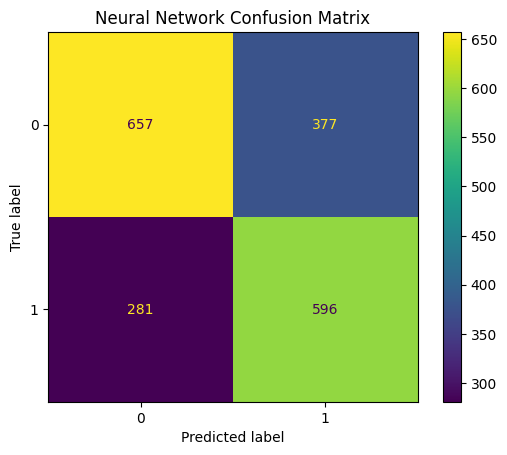

In [172]:
nn_y_pred_labels = np.argmax(nn_y_pred, axis=1)
cm = confusion_matrix(y_Test, nn_y_pred_labels, labels=nn.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nn.classes_)
disp.plot()
disp.ax_.set_title('Neural Network Confusion Matrix')
plt.show()